In [1]:
import matplotlib.pyplot as plt
import numpy as np

### Load data ###

In [2]:
def read_off(filename):
    """
    Reads an OFF or NOFF file of oriented points.

    Parameters:
    - filename (str): Path to the OFF/NOFF file.

    Returns:
    - points (np.ndarray): Array of points (vertices) with shape (n, 3).
    - normals (np.ndarray or None): Array of normals with shape (n, 3), or None if not present.
    """
    X = []
    N = []

    with open(filename, 'r') as infile:
        # Read and parse the header
        header = infile.readline().strip()
        if header not in {"OFF", "NOFF"}:
            raise ValueError(f"Invalid OFF file header: {header}")
        
        # Read the second line (number of vertices, faces, edges)
        info = infile.readline().strip()
        nvertices, nfaces, nedges = map(int, info.split())
        
        # Read the vertices (and optionally normals if NOFF)
        for _ in range(nvertices):
            line = infile.readline().strip()
            values = list(map(float, line.split()))
            
            x, y, z = values[:3]
            X.append([x, y, z])
            
            if header == "NOFF" and len(values) >= 6:  # If NOFF, normals are included
                nx, ny, nz = values[3:6]
                N.append([nx, ny, nz])
    
    # Convert lists to numpy arrays
    X = np.array(X)
    N = np.array(N) if N else None

    return X, N


In [3]:
data = read_off("cat.off")
X, N = data[0], data[1]


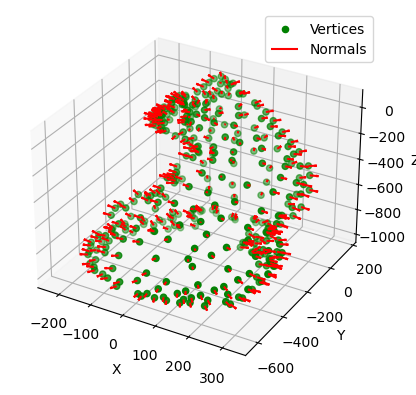

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot vertices
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c='g', label="Vertices", s=20)  # s controls marker size

# Plot normals using quiver
ax.quiver(X[:, 0], X[:, 1], X[:, 2],  # Starting points of arrows
          N[:, 0], N[:, 1], N[:, 2],  # Directions of arrows (normals)
          length=25, normalize=True, color='r', label="Normals")  # Adjust length as needed

# Add legend
ax.legend()

# Set labels for axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Show the plot
plt.show()


### Define Tessellation ###

In [5]:
def compute_bounding_box(X):
    min_x = np.min(X[:,0])
    max_x = np.max(X[:,0])
    min_y = np.min(X[:,1])
    max_y = np.max(X[:,1])
    min_z = np.min(X[:, 2])
    max_z = np.max(X[:, 2])
    return min_x, max_x, min_y, max_y, min_z, max_z

def compute_grid(X, min_x, max_x, min_y, max_y, min_z, max_z, cell_size=0.1, padding=0.2):
    x = np.linspace(min_x - padding, max_x + padding, int((max_x - min_x + 2 * padding) / cell_size))
    y = np.linspace(min_y - padding, max_y + padding, int((max_y - min_y + 2 * padding) / cell_size))
    z = np.linspace(min_z - padding, max_z + padding, int((max_z - min_z + 2 * padding) / cell_size))
    X, Y, Z = np.meshgrid(x, y, z, indexing='ij')  # 'ij' indexing for proper order
    return X, Y, Z

In [6]:
bounding_box = compute_bounding_box(X)
regular_grid = compute_grid(X, *bounding_box, cell_size=100, padding=200)
points = np.array([regular_grid[0].ravel(), regular_grid[1].ravel(), regular_grid[2].ravel()]).T
print(points.shape)
print(points[0])

(1512, 3)
[ -427.  -837. -1190.]


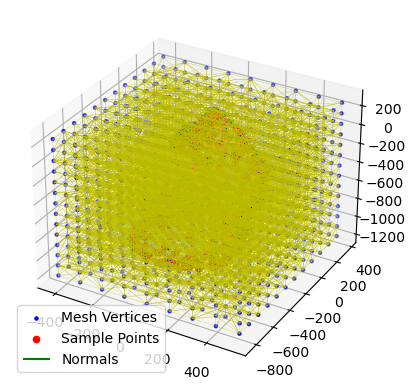

In [ ]:
from scipy.spatial import Delaunay
from mpl_toolkits.mplot3d.art3d import Line3DCollection
tessellation = Delaunay(points)

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot points
ax.scatter(points[:, 0], points[:, 1], points[:, 2], color='b', s=5, label="Mesh Vertices")
ax.scatter(X[:, 0], X[:, 1], X[:, 2], color='r', s=20, label="Sample Points")

# Plot normals
ax.quiver(X[:, 0], X[:, 1], X[:, 2], 
          N[:, 0], N[:, 1], N[:, 2], 
          length=25, normalize=True, color='g', label="Normals")

# Plot Delaunay tessellation edges
edges = []
for simplex in tessellation.simplices:
    for i in range(4):  # Tetrahedra have 4 vertices
        for j in range(i + 1, 4):  # Connect each pair of vertices
            edge = [simplex[i], simplex[j]]
            edges.append(points[edge])

# Create Line3DCollection from edges
edges = np.array(edges)
edge_collection = Line3DCollection(edges, colors='y', linewidths=0.1)
ax.add_collection3d(edge_collection)

ax.legend()
plt.show()


### Compute V ###

In [37]:
def compute_gradient_per_vertex(points, X, N, sigma=50.0):
    V = np.zeros((len(points), 3))
    for i in range(len(points)):
        for j in range(len(X)):
            weight = (np.exp(-np.linalg.norm(points[i] - X[j])**2 / (2 * np.pi * sigma**2)))
            V[i] += weight * N[j]
    return V

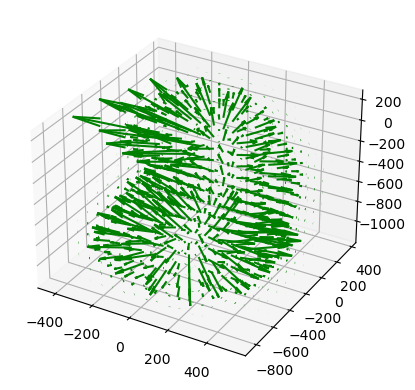

In [48]:
# Visualize V for each vertex
V_vertex = compute_gradient_per_vertex(points, X, N, sigma=50)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.quiver(points[:,0], points[:,1], points[:,2], V_vertex[:,0], V_vertex[:,1], V_vertex[:,2], length=25, normalize=False, color='g', label="Normals")
plt.show()

In [42]:
def compute_gradient_per_face(triangulation, V):
    F = np.zeros((len(triangulation.simplices), 3))
    for i, t in enumerate(triangulation.simplices):
        # Get the indices of the vertices of the triangle
        v0, v1, v2, v3 = t

        # Get the vertex gradients
        grad0 = V[v0]
        grad1 = V[v1]
        grad2 = V[v2]
        grad3 = V[v3]

        # Compute the barycentric interpolation (uniform averaging)
        face_gradient = (grad0 + grad1 + grad2 + grad3) / 4.0

        # Store the face gradient
        F[i] = face_gradient
    return F

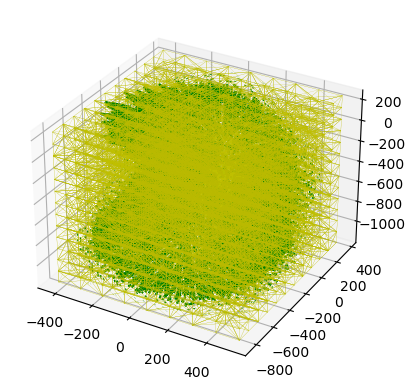

In [49]:
# Visualize V for each face
V_face = compute_gradient_per_face(tessellation, V_vertex)
centroids = np.mean(points[tessellation.simplices], axis=1)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
edge_collection = Line3DCollection(edges, colors='y', linewidths=0.1)
ax.add_collection3d(edge_collection)
ax.quiver(centroids[:, 0], centroids[:, 1], centroids[:, 2], 
        V_face[:, 0], V_face[:, 1], V_face[:, 2], 
        length=25, normalize=False, color='g', label="Normals")
plt.show()

### Solve Poisson Equation ###

In [50]:
from gpytoolbox import grad, cotangent_laplacian
import scipy.sparse as sp

In [51]:
# Compute the simplex-wise mass matrix for a 3D tetrahedral mesh.
def compute_mass_matrix(points, simplices):
    # Extract vertex positions for each simplex
    v0, v1, v2, v3 = points[simplices[:, 0]], points[simplices[:, 1]], points[simplices[:, 2]], points[simplices[:, 3]]

    # Compute the volume of each tetrahedron using the determinant method
    def compute_tetrahedron_volume(v0, v1, v2, v3):
        matrix = np.column_stack((v1 - v0, v2 - v0, v3 - v0))
        det = np.linalg.det(matrix)
        volume = abs(det) / 6.0
        return volume

    # Compute volumes for all tetrahedra
    volumes = np.array([compute_tetrahedron_volume(v0[i], v1[i], v2[i], v3[i]) for i in range(len(simplices))])

    # Create the diagonal mass matrix
    mass_matrix = np.diag(volumes)

    return mass_matrix


In [ ]:
print(points.shape)
print(tessellation.simplices.shape)
G = grad(points, tessellation.simplices) # TODO: implement grad function for 4-simplex
L = cotangent_laplacian(points, tessellation.simplices)
M_face = compute_mass_matrix(points, tessellation.simplices) 
M_g = sp.block_diag([M_face, M_face]) # "stretch" mass matrix from (m, m) to (2m, 2m) for x and y components in G matrix

# compute divergence of V 
D = G.T @ M_g @ V_face.T.flatten()

# solve the Poisson equation Ac = b <-> Lc = D
from scipy.sparse import linalg
A = L
b = D
c = linalg.spsolve(A, b)

(1512, 3)
(8312, 4)


UnboundLocalError: cannot access local variable 'G' where it is not associated with a value